In [3]:
import pandas as pd
import numpy as np
import nltk
import string
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
print(tf.__version__)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2.3.0


## 1. Загрузка данных

In [4]:
def load_movie_data (p_file_path):
    '''Загрузка данных о фильмах в датафрейм в формате id	title	genre	genre_id	description.
    Значения в файле должны разделяться символами " ::: ". 
    Информаци о новом фильме должна начинаться с ново строки
    
    :param p_file_path: путь к файлу
    :return DataFrame'''
    
    f = open(p_file_path)

    add_rows ={}
    index = 0
    for line in f:
        attributes = line.replace('\n', '').split(' ::: ')
       
        if len (attributes) < 4:
            continue
        
        add_rows[index] = {'id': attributes[0],
                           'title': attributes[1],
                           'genre': attributes[2],
                           'description': attributes[3]}
        
        index = index + 1
    
    #for

    f.close()
    
    return pd.DataFrame.from_dict(add_rows, "index")
    
#load_data

In [5]:
#загружаем данные для обучения
train_df = load_movie_data ('data/train_data.txt')

train_df

,id,title,genre,description
0,1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his doc...
1,2,Cupid (1997),thriller,A brother and sister with a past incestuous re...
2,3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fiel...
3,4,The Secret Sin (1915),drama,To help their unemployed father make ends meet...
4,5,The Unrecovered (2007),drama,The film's title refers not only to the un-rec...
...,...,...,...,...
54209,54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on B...
54210,54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The siste...
54211,54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about gr..."
54212,54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and have...


,genre,genre_cnt
0,drama,13613
1,documentary,13096
2,comedy,7447
3,short,5073
4,horror,2204
5,thriller,1591
6,action,1315
7,western,1032
8,reality-tv,884
9,family,784


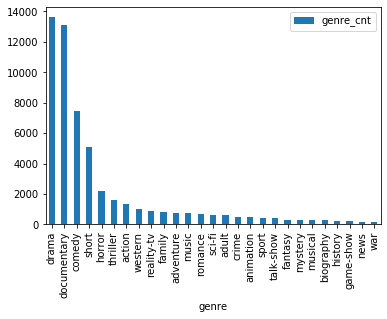

In [6]:
# Посмотрим распределение по жанрам

genre_count_df = train_df[['id','genre']].groupby('genre').agg('count').sort_values('id', ascending = False)

genre_count_df.reset_index(inplace = True)
genre_count_df.rename(columns ={'id':'genre_cnt'}, inplace = True)

genre_count_df.plot.bar(y = 'genre_cnt', x = 'genre')

genre_count_df

In [7]:
#Загружаем тестовые данные
test_df = load_movie_data ('data/test_data_solution.txt')

test_df

,id,title,genre,description
0,1,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apart..."
1,2,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty chi..."
2,3,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family o...
3,4,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with his..."
4,5,Er nu zhai (1955),drama,Before he was known internationally as a marti...
...,...,...,...,...
54195,54196,"""Tales of Light & Dark"" (2013)",horror,"Covering multiple genres, Tales of Light & Dar..."
54196,54197,Der letzte Mohikaner (1965),western,As Alice and Cora Munro attempt to find their ...
54197,54198,Oliver Twink (2007),adult,"A movie 169 years in the making. Oliver Twist,..."
54198,54199,Slipstream (1973),drama,"Popular, but mysterious rock D.J Mike Mallard ..."


## 2. Подготовка данных для модели


In [8]:
def tokenize_text (p_raw_text, p_stop_words):
    '''Функция для токенизации текста

    :param p_raw_text: исходная текстовая строка
    :param p_stop_words: список стоп слов
    '''
    
    tokenized_str = nltk.word_tokenize(p_raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in p_stop_words )]
    
    return filtered_tokens

#tokenize_text

In [9]:
#разбиваем описание на токены

train_df['description_tokenized'] = train_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))
test_df['description_tokenized'] = test_df['description'].apply(lambda x:tokenize_text(x, stopwords.words('english')))

In [10]:
# Подготовим частотный словарь для кодирования описаний

#Самые часто встречающийся токены (слова)
oov_tok = '<OOV>'
#Количество уникальных слов в словаре
vocab_size = 10000

train_data = train_df.description_tokenized.to_numpy()
tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
tokenizer.fit_on_texts(train_data)
word_index = tokenizer.word_index

dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 "'s": 2,
 "''": 3,
 '``': 4,
 'life': 5,
 'one': 6,
 'film': 7,
 'new': 8,
 'world': 9,
 'young': 10}

In [11]:
#Кодируем описания

#данные для обучения
train_sequences = tokenizer.texts_to_sequences(train_data)

#данные для проверки
test_data = test_df.description_tokenized.to_numpy()
test_sequences = tokenizer.texts_to_sequences(test_data)

print(train_sequences[11])
print()
print(test_sequences[11])

[1277, 1031, 2629, 233, 26, 100, 480, 192, 371, 34, 414, 885, 1, 8041, 3968, 1277, 2, 19, 150]

[69, 1248, 9, 1, 1, 2744, 233, 1434, 6916, 2307, 2118, 80, 131, 435, 4899, 4015, 121, 118, 36, 218, 393, 1209, 140, 1, 355, 86, 1, 3581, 1356, 887, 6916, 1990, 559]


минимальная длина описания: 4
средняя длина описания: 59
максимальная длина описания: 1481


(array([6.50572586e-03, 2.41776121e-04, 1.82331166e-05, 3.37187773e-06,
        6.24421801e-07, 2.49768720e-07, 1.24884360e-07, 2.49768720e-07,
        0.00000000e+00, 1.24884360e-07]),
 array([   4. ,  151.7,  299.4,  447.1,  594.8,  742.5,  890.2, 1037.9,
        1185.6, 1333.3, 1481. ]),
 <a list of 10 Patch objects>)

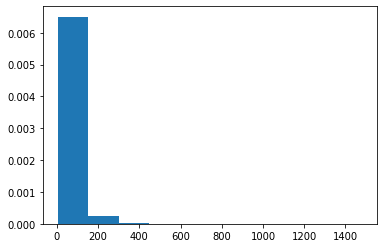

In [12]:
# Посчитаем среднюю длинну описания, чтобы определить длинну последовательности
train_df['description_len'] = train_df['description_tokenized'].apply (len)

print ('минимальная длина описания:', train_df.description_len.min())
print ('средняя длина описания:', round(train_df.description_len.mean()))
print ('максимальная длина описания:', train_df.description_len.max())

plt.hist(train_df.description_len, density = True)

In [13]:
# Приведем все цепочки в датасете к одной длине с помощью паддинга

MAX_SEQ_LEN = 70
trunc_type = 'post'
padding_type = 'post'

train_data = pad_sequences(train_sequences, maxlen=MAX_SEQ_LEN, padding=padding_type, truncating=trunc_type)
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQ_LEN, padding=padding_type, truncating=trunc_type)

print(train_data[11])
print()
print(test_data[11])

[1277 1031 2629  233   26  100  480  192  371   34  414  885    1 8041
 3968 1277    2   19  150    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]

[  69 1248    9    1    1 2744  233 1434 6916 2307 2118   80  131  435
 4899 4015  121  118   36  218  393 1209  140    1  355   86    1 3581
 1356  887 6916 1990  559    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0]


In [14]:
# Подготовим метки жанров для обучения и проверки

train_labels = [[genre] for genre in train_df.genre.values]
test_labels = [[genre] for genre in test_df.genre.values]

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(train_labels)

train_labels = np.array(label_tokenizer.texts_to_sequences(train_labels))
test_labels = np.array(label_tokenizer.texts_to_sequences(test_labels))

print(train_labels[0])
print(train_labels[1])
print(train_labels[2])
print(train_labels.shape)

print(test_labels[0])
print(test_labels[1])
print(test_labels[2])
print(test_labels.shape)

[1]
[6]
[15]
(54214, 1)
[6]
[3]
[2]
(54200, 1)


In [15]:
#Разбьем обучающий датасет на обучающий и валидационный
partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data, train_labels, 
                                                                  test_size = 0.20, random_state = 42)

print(partial_x_train.shape, partial_y_train.shape)
print(x_val.shape, y_val.shape)

(43371, 70) (43371, 1)
(10843, 70) (10843, 1)


## 3. Создание и обучение модели

In [16]:
# Создадим рекурентную модель для классификации

VOCAB_SIZE = vocab_size
# Размер векторного представления (эмбеддинга)
EMB_SIZE = 64
# Количество классов (жанров фильмов)
CLASS_NUM = 28

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=True, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(EMB_SIZE, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)),
    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
])

#model = tf.keras.Sequential([
#    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE, input_length=train_data.shape[1]),
#    tf.keras.layers.SpatialDropout1D(0.2),
#    tf.keras.layers.LSTM(EMB_SIZE, dropout=0.2, recurrent_dropout=0.2),
#    tf.keras.layers.Dense(CLASS_NUM, activation= 'softmax'),
#])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          640000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 28)                3612      
Total params: 808,476
Trainable params: 808,476
Non-trainable params: 0
_________________________________________________________________


In [17]:
#Обучение модели
BATCH_SIZE = 64
NUM_EPOCHS = 10

#Настраиваем объект для сохранения результатов работы модели
cpt_path = 'data/14_text_classifier.hdf5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='acc', verbose=1, save_best_only= True, mode='max')

model.compile(loss= 'sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])

#запускаем обучение
history= model.fit(partial_x_train, partial_y_train, validation_data= (x_val, y_val), 
                   epochs= NUM_EPOCHS, batch_size= BATCH_SIZE, verbose= 1,
                   callbacks=[checkpoint])


Epoch 1/10
678/678 [==============================] - ETA: 0s - loss: 2.0472 - acc: 0.4050
Epoch 00001: acc improved from -inf to 0.40504, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 97s 143ms/step - loss: 2.0472 - acc: 0.4050 - val_loss: 1.7987 - val_acc: 0.4717
Epoch 2/10
678/678 [==============================] - ETA: 0s - loss: 1.6577 - acc: 0.5191
Epoch 00002: acc improved from 0.40504 to 0.51910, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 99s 147ms/step - loss: 1.6577 - acc: 0.5191 - val_loss: 1.6488 - val_acc: 0.5131
Epoch 3/10
678/678 [==============================] - ETA: 0s - loss: 1.4850 - acc: 0.5711
Epoch 00003: acc improved from 0.51910 to 0.57114, saving model to data/14_text_classifier.hdf5
678/678 [==============================] - 99s 146ms/step - loss: 1.4850 - acc: 0.5711 - val_loss: 1.6227 - val_acc: 0.5279
Epoch 4/10
678/678 [==============================] - ETA: 0s - loss: 

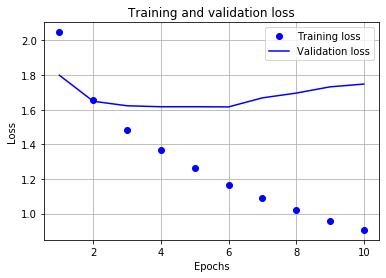

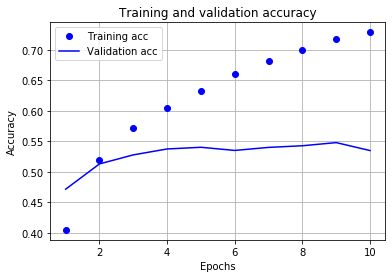

In [18]:
#отобразим графики обучения

epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [19]:
# оценим качество на тестовом датасете

results = model.evaluate(test_data, test_labels)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 28s 17ms/step - loss: 1.7774 - acc: 0.5335
Test loss: 1.7774
Test accuracy: 53.35 %
